---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [58]:
import pandas as pd
import numpy as np
#%matplotlib inline
#import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


def blight_model():
    
    # Your code here
    df_ori = pd.read_csv('train.csv', encoding='ISO-8859-1')
    df_address = pd.read_csv('addresses.csv')
    df_latlons = pd.read_csv('latlons.csv')
    df_loc = pd.merge(df_address,df_latlons,left_on='address',right_on='address',how='inner')
    df_all = pd.merge(df_ori, df_loc, how='inner',on='ticket_id')
    
    common = ['ticket_id','agency_name', 'inspector_name','violation_code' ,'disposition',
             'fine_amount','late_fee', 'discount_amount','judgment_amount','lat', 'lon', 'compliance']

    df_train = df_all[common]
    df_train.dropna(subset=['compliance'],inplace=True)
    countv = df_train['violation_code'].value_counts()
    cat_tokeepv = countv[countv>100].index.tolist()
    df_train['violation_code'] = pd.Categorical(df_train['violation_code'], categories=cat_tokeepv, ordered=True)
    df_train['violation_code'] = df_train['violation_code'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_train['violation_code'] = df_train['violation_code'].cat.codes

    counta = df_train['agency_name'].value_counts()
    #cat_tokeep = counta[counta>100].index.tolist()
    df_train['agency_name'] = pd.Categorical(df_train['agency_name'], categories=counta.index.tolist(), ordered=True)
    df_train['agency_name'] = df_train['agency_name'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_train['agency_name'] = df_train['agency_name'].cat.codes

    counti = df_train['inspector_name'].value_counts()
    cat_tokeepi = counti[counti>100].index.tolist()
    df_train['inspector_name'] = pd.Categorical(df_train['inspector_name'], categories=cat_tokeepi, ordered=True)
    df_train['inspector_name'] = df_train['inspector_name'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_train['inspector_name'] = df_train['inspector_name'].cat.codes

    df_train['disposition'] = pd.Categorical(df_train['disposition'], ordered=True)
    df_train['disposition'] = df_train['disposition'].cat.codes
    X = df_train[['agency_name','inspector_name','violation_code','disposition','fine_amount','late_fee','discount_amount','judgment_amount','lat','lon']].fillna(0)
    y = df_train['compliance']
    X_proce = MinMaxScaler().fit_transform(X)
    X_train, X_test, y_train, y_test =train_test_split(X_proce, y, random_state=0)
    clf = RandomForestRegressor(random_state=0)
    param_grid = {'max_depth':[5,6,7,8,9,10],'max_features':[2,3,4,5,6,7,8,9]}

    gdcv = GridSearchCV(clf,param_grid=param_grid, cv=5, scoring='roc_auc',)
    gdcv.fit(X_train, y_train)
    roc_auc_score(y_test, gdcv.predict(X_test))
    
    df_test = pd.read_csv('test.csv',encoding='latin1')
    df_merge = pd.merge(df_test, df_loc, on='ticket_id',how='inner')
    df_merge.set_index('ticket_id', inplace=True)
    df_merge = df_merge[['agency_name', 'inspector_name','violation_code' ,'disposition',
                         'fine_amount','late_fee', 'discount_amount','judgment_amount','lat', 'lon', ]]
    countvt = df_merge['violation_code'].value_counts()
    cat_tokeepvt = countvt[countvt>100].index.tolist()
    df_merge['violation_code'] = pd.Categorical(df_merge['violation_code'], categories=cat_tokeepvt, ordered=True)
    df_merge['violation_code'] = df_merge['violation_code'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_merge['violation_code'] = df_merge['violation_code'].cat.codes

    countat = df_merge['agency_name'].value_counts()
    #cat_tokeep = counta[counta>100].index.tolist()
    df_merge['agency_name'] = pd.Categorical(df_merge['agency_name'], categories=countat.index.tolist(), ordered=True)
    df_merge['agency_name'] = df_merge['agency_name'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_merge['agency_name'] = df_merge['agency_name'].cat.codes

    countit = df_merge['inspector_name'].value_counts()
    cat_tokeepit = countit[countit>100].index.tolist()
    df_merge['inspector_name'] = pd.Categorical(df_merge['inspector_name'], categories=cat_tokeepit, ordered=True)
    df_merge['inspector_name'] = df_merge['inspector_name'].cat.add_categories('<unknown>').fillna('<unknown>')
    df_merge['inspector_name'] = df_merge['inspector_name'].cat.codes

    df_merge['disposition'] = pd.Categorical(df_merge['disposition'], ordered=True)
    df_merge['disposition'] = df_merge['disposition'].cat.codes
    df_merge.fillna(0,inplace=True)
    
    return pd.Series(gdcv.predict(df_merge),index=df_merge.index)
blight_model()

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

ticket_id
284932    0.7
285362    0.7
285361    0.7
285338    0.7
285346    0.7
285345    0.7
285347    0.7
285342    0.4
285530    0.7
284989    0.7
285344    0.8
285343    0.7
285340    0.7
285341    0.8
285349    0.7
285348    0.7
284991    0.7
285532    0.7
285406    0.7
285001    0.7
285006    0.7
285405    0.7
285337    0.7
285496    0.8
285497    0.7
285378    0.7
285589    0.7
285585    0.7
285501    0.7
285581    0.7
         ... 
376367    0.7
376366    0.7
376362    0.7
376363    0.7
376365    0.7
376364    0.7
376228    0.7
376265    0.7
376286    0.4
376320    0.7
376314    0.7
376327    0.4
376385    0.4
376435    0.4
376370    0.4
376434    0.7
376459    0.7
376478    0.7
376473    0.7
376484    0.7
376482    0.7
376480    0.7
376479    0.7
376481    0.7
376483    0.7
376496    0.7
376497    0.7
376499    0.7
376500    0.7
369851    0.5
dtype: float64

In [3]:
'''df_ori = pd.read_csv('train.csv', encoding='ISO-8859-1')
df_address = pd.read_csv('addresses.csv')
df_latlons = pd.read_csv('latlons.csv')
df_loc = pd.merge(df_address,df_latlons,left_on='address',right_on='address',how='inner')
df_all = pd.merge(df_ori, df_loc, how='inner',on='ticket_id')
common = ['ticket_id','agency_name', 'inspector_name','violation_code' ,'disposition',
         'fine_amount','late_fee', 'discount_amount','judgment_amount','lat', 'lon', 'compliance']


df_train = df_all[common]'''

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
'''df_test = pd.read_csv('test.csv',encoding='latin1')
df_merge = pd.merge(df_test, df_loc, on='ticket_id',how='inner')
df_merge.set_index('ticket_id', inplace=True)
df_merge = df_merge[['agency_name', 'inspector_name','violation_code' ,'disposition',
                     'fine_amount','late_fee', 'discount_amount','judgment_amount','lat', 'lon', ]]
df_merge.head()'''

,agency_name,inspector_name,violation_code,disposition,fine_amount,late_fee,discount_amount,judgment_amount,lat,lon
ticket_id,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B",22-2-61,Responsible by Default,200.0,20.0,0.0,250.0,42.407581,-82.986642
285362,Department of Public Works,"Lusk, Gertrina",22-2-88(b),Responsible by Default,1000.0,100.0,0.0,1130.0,42.426239,-83.238259
285361,Department of Public Works,"Lusk, Gertrina",22-2-43,Responsible by Default,100.0,10.0,0.0,140.0,42.426239,-83.238259
285338,Department of Public Works,"Talbert, Reginald",22-2-88(b),Responsible by Default,200.0,20.0,0.0,250.0,42.309661,-83.122426
285346,Department of Public Works,"Talbert, Reginald",22-2-45,Responsible by Default,100.0,10.0,0.0,140.0,42.308830,-83.121116


In [51]:
'''countvt = df_merge['violation_code'].value_counts()
cat_tokeepvt = countvt[countvt>100].index.tolist()
df_merge['violation_code'] = pd.Categorical(df_merge['violation_code'], categories=cat_tokeepvt, ordered=True)
df_merge['violation_code'] = df_merge['violation_code'].cat.add_categories('<unknown>').fillna('<unknown>')
df_merge['violation_code'] = df_merge['violation_code'].cat.codes

countat = df_merge['agency_name'].value_counts()
#cat_tokeep = counta[counta>100].index.tolist()
df_merge['agency_name'] = pd.Categorical(df_merge['agency_name'], categories=countat.index.tolist(), ordered=True)
df_merge['agency_name'] = df_merge['agency_name'].cat.add_categories('<unknown>').fillna('<unknown>')
df_merge['agency_name'] = df_merge['agency_name'].cat.codes

countit = df_merge['inspector_name'].value_counts()
cat_tokeepit = countit[countit>100].index.tolist()
df_merge['inspector_name'] = pd.Categorical(df_merge['inspector_name'], categories=cat_tokeepit, ordered=True)
df_merge['inspector_name'] = df_merge['inspector_name'].cat.add_categories('<unknown>').fillna('<unknown>')
df_merge['inspector_name'] = df_merge['inspector_name'].cat.codes

df_merge['disposition'] = pd.Categorical(df_merge['disposition'], ordered=True)
df_merge['disposition'] = df_merge['disposition'].cat.codes

df_merge.head()'''

,agency_name,inspector_name,violation_code,disposition,fine_amount,late_fee,discount_amount,judgment_amount,lat,lon
ticket_id,,,,,,,,,,
284932,0,20,11,5,200.0,20.0,0.0,250.0,42.407581,-82.986642
285362,0,1,1,5,1000.0,100.0,0.0,1130.0,42.426239,-83.238259
285361,0,1,7,5,100.0,10.0,0.0,140.0,42.426239,-83.238259
285338,0,39,1,5,200.0,20.0,0.0,250.0,42.309661,-83.122426
285346,0,39,3,5,100.0,10.0,0.0,140.0,42.308830,-83.121116


In [61]:
'''df_ori = pd.read_csv('train.csv', encoding='ISO-8859-1')
df_address = pd.read_csv('addresses.csv')
df_latlons = pd.read_csv('latlons.csv')
df_loc = pd.merge(df_address,df_latlons,left_on='address',right_on='address',how='inner')
df_all = pd.merge(df_ori, df_loc, how='inner',on='ticket_id')

common = ['ticket_id','agency_name', 'inspector_name','violation_code' ,'disposition',
         'fine_amount','late_fee', 'discount_amount','judgment_amount','lat', 'lon', 'compliance']

df_train = df_all[common]
df_train.dropna(subset=['compliance'],inplace=True)
countv = df_train['violation_code'].value_counts()
cat_tokeepv = countv[countv>100].index.tolist()
df_train['violation_code'] = pd.Categorical(df_train['violation_code'], categories=cat_tokeepv, ordered=True)
df_train['violation_code'] = df_train['violation_code'].cat.add_categories('<unknown>').fillna('<unknown>')
df_train['violation_code'] = df_train['violation_code'].cat.codes

counta = df_train['agency_name'].value_counts()
#cat_tokeep = counta[counta>100].index.tolist()
df_train['agency_name'] = pd.Categorical(df_train['agency_name'], categories=counta.index.tolist(), ordered=True)
df_train['agency_name'] = df_train['agency_name'].cat.add_categories('<unknown>').fillna('<unknown>')
df_train['agency_name'] = df_train['agency_name'].cat.codes

counti = df_train['inspector_name'].value_counts()
cat_tokeepi = counti[counti>100].index.tolist()
df_train['inspector_name'] = pd.Categorical(df_train['inspector_name'], categories=cat_tokeepi, ordered=True)
df_train['inspector_name'] = df_train['inspector_name'].cat.add_categories('<unknown>').fillna('<unknown>')
df_train['inspector_name'] = df_train['inspector_name'].cat.codes

df_train['disposition'] = pd.Categorical(df_train['disposition'], ordered=True)
df_train['disposition'] = df_train['disposition'].cat.codes
X = df_train[['agency_name','inspector_name','violation_code','disposition','fine_amount','late_fee','discount_amount','judgment_amount','lat','lon']].fillna(0)
y = df_train['compliance']
X_proce = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test =train_test_split(X_proce, y, random_state=0)
clf = RandomForestClassifier(random_state=0)
param_grid = {'max_depth':[13,],'max_features':[10]}

gdcv = GridSearchCV(clf,param_grid=param_grid, cv=5, scoring='roc_auc',)
gdcv.fit(X_train, y_train)
roc_auc_score(y_test, gdcv.predict(X_test))'''

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

0.62782542383642359

In [56]:
'''pd.Series(gdcv.predict(df_merge),index=df_merge.index)'''

ticket_id
284932    0.516038
285362    0.516038
285361    0.516038
285338    0.516038
285346    0.516038
285345    0.516038
285347    0.516038
285342    0.300000
285530    0.516038
284989    0.516038
285344    0.716038
285343    0.516038
285340    0.516038
285341    0.716038
285349    0.516038
285348    0.516038
284991    0.516038
285532    0.516038
285406    0.516038
285001    0.516038
285006    0.516038
285405    0.516038
285337    0.516038
285496    0.716038
285497    0.516038
285378    0.516038
285589    0.516038
285585    0.516038
285501    0.516038
285581    0.516038
            ...   
376367    0.516038
376366    0.516038
376362    0.516038
376363    0.516038
376365    0.516038
376364    0.516038
376228    0.516038
376265    0.516038
376286    0.300000
376320    0.516038
376314    0.516038
376327    0.300000
376385    0.300000
376435    0.300000
376370    0.300000
376434    0.516038
376459    0.516038
376478    0.516038
376473    0.516038
376484    0.516038
376482    0.516038
37

In [28]:
'''X = df_train[['agency_name','inspector_name','violation_code','disposition','fine_amount','late_fee','discount_amount','judgment_amount','lat','lon']].fillna(0)
y = df_train['compliance']
X_proce = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test =train_test_split(X_proce, y, random_state=0)'''

In [42]:
'''clf = RandomForestRegressor()
param_grid = {'max_depth':[11,],'max_features':[10]}

gdcv = GridSearchCV(clf,param_grid=param_grid, cv=5, scoring='roc_auc',)
gdcv.fit(X_train, y_train)
'''

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10], 'max_depth': [8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [43]:
'''gdcv.best_score_,gdcv.best_params_'''

(0.81149241281590112, {'max_depth': 11, 'max_features': 10})

In [44]:
'''from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, gdcv.predict(X_test))'''

0.81127744084337339

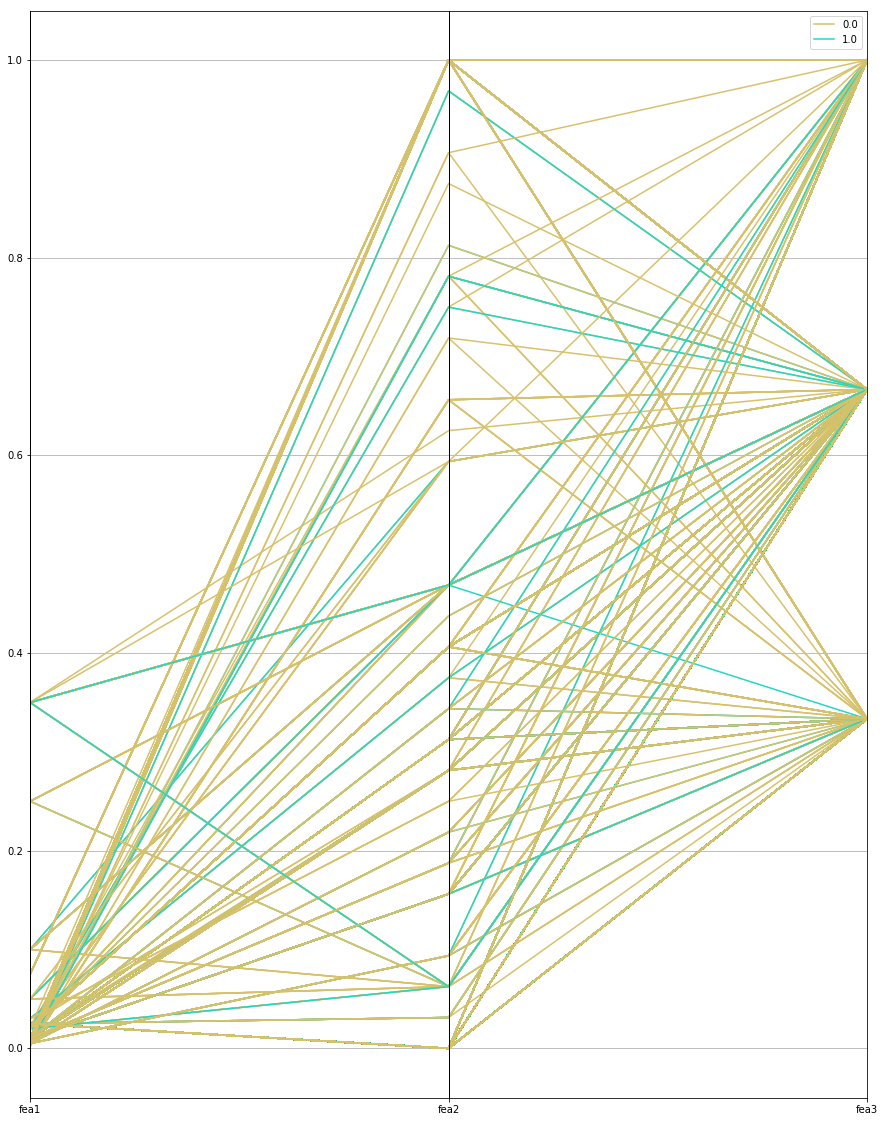

In [127]:
'''plt.figure(figsize=(15,20))
pd.tools.plotting.parallel_coordinates(df[:5000], 'target')'''